In [49]:
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import curve_fit
from xcor_tools_1820 import make_binned_lc, make_1Dlightcurve, find_nearest
from numpy.fft import fft, fftfreq
from stingray import Lightcurve
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [51]:
data_dir = r"/Users/meg/Documents/Research/Obs/V339Del_complied_sorted.fits"
data = Table.read(data_dir, format='fits')

save_txt_for_Elias = False

if save_txt_for_Elias is True:
#     f = open('V339Del_compiled_sorted.txt', 'w')
#     f.write(str(data))
#     f.close()
    ascii.write(data, 'V339Del_compiled_sorted.txt')
    print("saved a txt version of data for Elias")

time = data['time (JD)']
Vmag = data['Vmag']
Verr = data['Verr']
date_mask = time >= 2458650.0
time = time[date_mask]
Vmag = Vmag[date_mask]
Verr = Verr[date_mask]


saved a txt version of data for Elias


In [59]:
# #quick testing of the txt file
# import glob
# import pandas as pd
# #total .txt files in directory
# total = glob.glob('*.txt')
# print(total)
# data = pd.read_csv(total[0],sep = ' ',index_col=False )

# data['time (JD)'][0]

2458630.6025799997

Text(0, 0.5, 'Vmag (JD)')

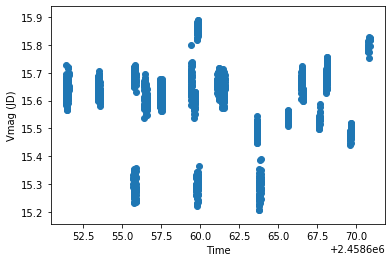

In [11]:
plt.scatter(time, Vmag)
plt.xlabel('Time')
plt.ylabel('Vmag (JD)')

## To do: 

-  Need to detrend the data/ don't use the real magnitude, get the delta Vmag or so!
-  Normalize the powerspectrum
-  Errorbars

In [37]:
lc = Lightcurve(time, Vmag)
fft_ = fft(lc.counts)
nyquist = 1/(2*lc.dt)
print("nyquist: ", nyquist)
freq = fftfreq(len(Vmag),lc.dt)
print(freq)
#Freq mask
mask = freq > 0
freq_masked = freq[mask]
print(freq)
fft_masked = fft_[mask]
power_masked = np.multiply(fft_masked, np.conj(fft_masked))

nyquist:  632.9110499005902
[ 0.          0.6247888   1.24957759 ... -1.87436639 -1.24957759
 -0.6247888 ]
[ 0.          0.6247888   1.24957759 ... -1.87436639 -1.24957759
 -0.6247888 ]


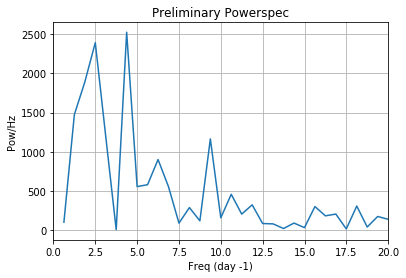

In [39]:
plt.plot(freq_masked, power_masked)
plt.xlabel('Freq (day -1)')
plt.ylabel('Pow/Hz')
plt.title("Preliminary Powerspec")
plt.xlim(0,20)
plt.grid()
plt.savefig("339Del_prelim_powerspec.png", overwrite = False)

In [28]:
# I don't think this is it
start_times = np.asarray([])
stop_times = np.asarray([])


n_seg = 0
n_day = 1.0
n_bins = 100.

dt = 1/1.05

freq = fftfreq(int(n_bins), d=dt)
mask = freq > 0
freq = freq[mask]
df = np.median(np.diff(freq))

nyquist = 1.0 / (2.0 * dt)
print("nyquist:", nyquist)
print("dt:", dt)
print("df:", df)
psd_seg = np.zeros(len(freq), dtype='complex128')
print("length of psd: ", len(psd_seg))

start_time = time[0]
final_time = time[-1]
end_time = start_time + n_day

while end_time <= final_time:
    seg_mask = ((time >= start_time) & (time <= end_time)) 
    time_seg = time[seg_mask]
    vmag_seg = Vmag[seg_mask]
    if len(time_seg) > 0:
        lc = make_1Dlightcurve(time_seg, n_bins, start_time, end_time)
        fft_ = fft(lc)
        #Freq mask
        fft_ = fft_[mask]
        #print("length of fft: ",len(fft_))
        psd_seg += np.multiply(fft_, np.conj(fft_))

        ## Increment for next segment
        n_seg += 1
        if n_seg % 10 == 0 and n_seg != 0:
            print("\t%d" % n_seg)
            
    start_time = end_time
    end_time = start_time + n_day

psd_seg /= n_seg
print("Total number of segments: %d" % n_seg)



#data = np.column_stack((blah, blah2))
#np.savetxt("./data.txt",data, fmt="%.12f")

nyquist: 0.525
dt: 0.9523809523809523
df: 0.01050000000000001
length of psd:  49
	10
Total number of segments: 13


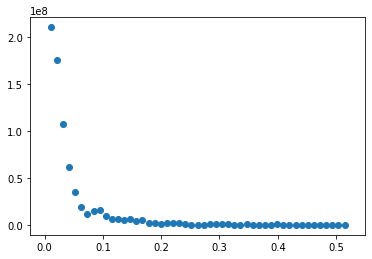

In [29]:
plt.scatter(freq, psd_seg)
#plt.xlim(-0.1,0.1)
#10 hr period might be the best
# longest is 5 days, hopefully not that

In [8]:
# from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

In [9]:
# time_int = time.astype(float)
# vmag_ft = Vmag.astype(float)
# lc = Lightcurve(time, vmag_ft)
# lc.plot()

In [10]:
# ps = Powerspectrum(lc, norm='frac')
# ps.plot(axis=(0,20,0, 0.0001))

In [11]:
# meanest = np.mean(lc.countrate)
# poisson = 2./meanest
# ps.power -= poisson


In [12]:
# ps.plot(axis=(0,20,0, 0.0002))

In [13]:
# avg = AveragedPowerspectrum(lc, 1.5, norm='frac' )
# meanest = np.mean(lc.countrate)
# poisson = 2./meanest
# avg.power -= poisson
# rebin = avg.rebin_log(f=0.05)

In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
# ax.errorbar(rebin.freq,abs(rebin.power),yerr=rebin.power_err, 
#             lw=1, drawstyle='steps-mid', color='black')
# #ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
# ax.set_ylabel("Power/Hz", fontproperties=font_prop)
# ax.tick_params(axis='both', which='major', labelsize=16, 
#                top=True, right=True, bottom=True, left=True)
# ax.set_title("Noisy Power Spectrum of V339Del ")
# ax.set_xlim(0,20)

# plt.grid()
